### Output for app and downloadbale jsons


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import re
from textwrap import wrap
import matplotlib.ticker
import os
import seaborn as sns

idx = pd.IndexSlice

### This notebook is just about putting the files together for the app and creating json file for downloads
1. Output has to be in form dict or list or list of dicts
2. if its going to a js library it will have to be parsed on the far side
3. string output for dates is OK for js parser
4. dict output can go directly to python templates

#### Although this may seem like boring stuff, this where the automation process starts:

1. Indentify attributes you want to measure/compare/visualise
2. Create away to index those attributes through a variable 
3. Introduce that variable as an argument to a function.
4. makse sure that function doses what you want

#### so some of the charts here will become interactive on the app... and update as the data updates

In [2]:
here = os.getcwd()
j_data = here + '/data/json/'

In [3]:
## open up the dfs
def get_jsons(file_name):
    a = pd.read_json(j_data + file_name, orient='index')
    return a

In [4]:
dfs = ['m_b_2016.json','m_b_2017.json', 'rain_2016.json','m_b_201724.json', 'm_b_201748.json', 'rain_2017.json']

In [5]:
m_b_2016 = get_jsons(dfs[0])
m_b_2017 = get_jsons(dfs[1])
rain_2016 = get_jsons(dfs[2])
m_b_201724 = get_jsons(dfs[3])
m_b_201748 = get_jsons(dfs[4])
rain_2017 = get_jsons(dfs[5])

In [6]:
# check how the tools work in this environment
# not the same function as before, removed index

def get_jsons_x(file_name):
    with open(j_data + file_name, 'r') as f:
        a = json.load(f)
    return a
date_week16 = get_jsons_x('date_week16.json')

In [7]:
j_data

'/home/mw-shovel/web/notes/micro/data/json/'

In [8]:
week_date16 = get_jsons_x('week_date16.json')
colony_map_16 = get_jsons_x('colony_map_16.json')
three_plate_16 = get_jsons_x('three_plate_16.json')
# so now we need the weekly average per colony, per week, per location
# for that we need to call dates
week_date16 = get_jsons_x('week_date16.json')
date_week16 = get_jsons_x('date_week16.json')
places = get_jsons_x('places.json')
mediums = get_jsons_x('mediums.json')

In [9]:
m_b_2016.set_index(['Date', 'Location'], inplace=True)
m_b_2016.sort_index(axis=0, level='Date', ascending=True, inplace=True)
#m_b_2016[three_plate_16[0][1]][:3]#<----should now be sorted by date

In [10]:
a_color_week = m_b_2016.loc[idx[week_date16['Week one'], places[0]], three_plate_16[0]]#<----- by changing the index numbers change location and colony

In [11]:
# this will give all the values for a color group for the entire project:
# m_b_2016.loc[m_b_2016.Location == places [2], three_plate_16[3]]
a_color_week.apply('mean', axis=1)#<------ gives the average of the row

Date        Location
2016-06-21  MRD         0.666667
dtype: float64

In [12]:
a_color_week.apply('mean', axis=1).item()#<---- gives the number that we need

0.6666666666666666

In [13]:
columns_2017 = m_b_2017.columns

In [14]:
# iterate through the colonies:
def colony_avg(df, dates, place, plates):
    a = df.loc[idx[dates, place], plates]
    b = df.loc[idx[dates, place], 'P1_qty_sample'].item()
    c = 100/b 
    d = a.apply('mean', axis=1).item()
    if d == 0:
        d = 1/len(plates)
        f = colony_map_16[plates[0]]
        e = d*c
        return e, f, b
    elif d > 0:
        e =d*c
        f = 'none'
        return e, f, b

In [15]:
# iterate by week
def weekly_avg(df, dates, place, plat_s):
    d = []
    e = []
    for plates in plat_s:
        a, b, c = colony_avg(df, dates, place, plates)
        d.append(a)
        if b != 'none':
            e.append(b)
    f = ', '.join(e)
        
    return [{date_week16[dates]:d}, {'BDL':f}, {'dilution':c}]

In [16]:
# add admin data
def place_weekly_avg(df, dates, place, plat_s):
    a = weekly_avg(df, dates, place, plat_s)
    a.append({'num samps':len(plat_s[0])})
    return a


In [17]:
# group by place then week
def place_by_week(df, dates, places, plates):
    d = []
    for place in places:
        b = []
        for date in dates:            
            a= place_weekly_avg(df, date, place, plates)
            b.append(a)
        c = {place:b}
        d.append(c)
    return d
    
bar_charts = place_by_week(m_b_2016, list(date_week16.keys()), places[:], three_plate_16)
bar_charts[0]['MRD'][0][0]#<--- gives the average colony count per group/week/location---

{'Week one': [66.66666666666666,
  466.6666666666667,
  100.0,
  266.66666666666663,
  33.33333333333333]}

In [18]:
bar_charts[0]['MRD'][0][1]#<--- changing this number gives other data, colony types below detetectable limit

{'BDL': 'other'}

In [19]:
bar_charts[0]['MRD'][0][2]#<----- dilution factor

{'dilution': 1.0}

In [20]:
bar_charts[0]['MRD'][0][3]#<------ how many samples were taken

{'num samps': 3}

In [21]:
m_b_201724.set_index(['Date', 'Location'], inplace=True)
m_b_201724.sort_index(axis=0, level='Date', ascending=True, inplace=True)

In [22]:
week_date = get_jsons_x('week_date.json')
date_week = get_jsons_x('date_week.json')
three_p_24_17 = get_jsons_x('three_p_24_17.json')
colony_map = get_jsons_x('colony_map.json')

In [23]:
colony_map_17_24 = {'P1_24h_big_blue': 'big_blue','P1_fluo_halo_colonies': 'UV Fluo','P1_24h_med_blue': 'med_blue',
                    'P1_24h_turq': 'turq','P1_24h_green': 'green','P1_24h_pink': 'pink','P1_24h_other': 'other',
                    'P2_24h_big_blue': 'big_blue','P2_fluo_halo_colonies': 'UV Fluo','P2_24h_med_blue': 'med_blue',
                    'P2_24h_turq': 'turq','P2_24h_green': 'green','P2_24h_pink': 'pink','P2_24h_other': 'other',
                    'P3_24h_big_blue': 'big_blue','P3_flucolony_map_17_24o_halo_colonies': 'UV Fluo','P3_24h_med_blue': 'med_blue',
                    'P3_24h_turq': 'turq','P3_24h_green': 'green','P3_24h_pink': 'pink','P3_24h_other': 'other'}


In [24]:
def colony_avg_17(df, dates, place, plates):
    a = df.loc[idx[dates, place], plates]
    b = df.loc[idx[dates, place], 'P1_qty_sample'].item()
    g = df.loc[idx[dates, place], 'Samples'].item()
    c = 100/b 
    d = a.apply('mean', axis=1).item()
    if g == 0:
        e = 0
        f = 'no sample'
        return e, f, b, g        
    elif d == 0:
        d = 1/len(plates)
        f = colony_map_17_24[plates[0]]
        e = d*c
        return e, f, b, g
    elif d > 0:
        e =d*c
        f = 'none'
        return e, f, b, g

In [25]:
# iterate by week
def weekly_avg_17(df, dates, place, plat_s):
    d = []
    e = []
    for plates in plat_s:
        a, b, c, g = colony_avg_17(df, dates, place, plates)
        d.append(a)
        if b != 'none':
            e.append(b)
    if g == 0:
        f = e[0]
    elif g != 0:
        f = ', '.join(e)
        
    return [{date_week[dates]:d}, {'BDL':f}, {'dilution':c}, {'num samps':g}]

In [26]:
# add admin data
def place_weekly_avg_17(df, dates, place, plat_s):
    a = weekly_avg_17(df, dates, place, plat_s)   
    return a

In [27]:
# group by place then week
def place_by_week_17(df, dates, places, plates):
    d = []
    for place in places:
        b = []
        for date in dates:            
            a= place_weekly_avg_17(df, date, place, plates)
            b.append(a)
        c = {place:b}
        d.append(c)
    return d

In [28]:
a_i = m_b_201724.loc[m_b_201724.medium == 'easy_gel'].copy()
a_i.loc[idx['2017-07-24','MRD'], 'Samples'] = 0
bar_chart_17 = place_by_week_17(a_i, list(date_week.keys()), places[:], three_p_24_17)
week_days = list(week_date.keys())

In [29]:
# so to get the average weekly total of all colony forming units
# I will add up the averages of the individual colors(already calculated to make the average grid)
# and we will grab only the coliforms --- using UV for big_blue

def total_cfu(c, v, q):
    # c = list of the weeks of the study 'Week one', 'Week two' ....
    # v = list of the locations indentified for summary
    # q = the results from the grid layout fundtion
    # place to store the results
    b = {}
    # go through the locations one after another
    for n, x in enumerate(v):
        # place to store interim results
        e = []
        # go through the results of each location, week by week
        for i, w in enumerate(c):
            # q[n][v[n]][i][0][w] translates to
            # four_eight_ave[0][places_48[0][0][0]['Week one']]
            # if this was the first location through the function
            a = q[n][v[n]][i][0][w]
            if type(a) == dict:
                # if there is no value or it is 'bdl'
                # take the average of the current results and append to e
                d=np.mean(e)
            else:
                # if the result is anything else sum it up
                # this is the list of results for the bar charts
                d = sum(a)
            # take d and put it in e
            e.append(d)
        # get the standard deviation
        f = np.std(e)
        # make a string to indentify the std
        # this will be component of the error bars
        string = x + '_std'
        # put all of that in a dict so it acan be called in a plotting function
        b.update({x:e, string:f})
    
    return b

In [30]:
t_cfu = total_cfu(week_days, places, bar_charts)

In [31]:
rain_2016.sort_values('Date', inplace=True)
date_list = sorted(list(week_date16.values()))
samp_date = sorted(list(date_week16.keys()))
samp_date = [pd.to_datetime(x) for x in samp_date]

In [32]:
t_cfu17 = total_cfu(week_days, places, bar_chart_17)

In [33]:
rain_2017['Date'] = pd.to_datetime(rain_2017['Date'])
rain_2017.sort_values('Date', inplace=True)
date_list17 = sorted(list(week_date.values()))
samp_date17 = sorted(list(date_week.keys()))
samp_date17 = [pd.to_datetime(x) for x in samp_date17]

In [34]:
def not_simple_plot(arange, values, datelist, ticklocs, places,rain, xtiks,sup_title, title, filename):
    collss=['darkred', 'darkslategray', 'teal']
    nticks = 8
    fig, ax2 = plt.subplots(figsize=(10,6), edgecolor='midnightblue')
    x = datelist
    y = values
    locs = ticklocs
    labels = week_days
    x_one = rain['Date']
    y_one = rain['Rain']
    ylim = [1]
    for i, n in enumerate(places):
        string = n + '_std'
        std = y[string]
        ratio = std/max(y[n])
        for j, o in enumerate(x):
            t, c, j = ax2.errorbar(x[j], y[n][j], yerr=y[n][j]*ratio, capsize=2, alpha=0.4, ecolor='magenta',)
            for k in j:
                k.set_linestyle('--')
            for cap in c:
                cap.set_marker("o")
        ax2.plot(x, y[n], label=n, color=collss[i], linewidth=3)
        if max(y[n]) > max(ylim):
            ylim.append(max(y[n]))
        ax2.set_ylim(bottom=0, top=max(ylim)+100)
    ax1 = ax2.twinx() 
    ax1.bar(x_one, y_one.values, width=1, color='b', alpha=0.2, label="cm of rain")
      
    ax1.spines['bottom'].set_color('midnightblue')
    ax1.spines['top'].set_color('midnightblue')
    ax1.spines['left'].set_color('midnightblue')
    ax1.spines['right'].set_color('midnightblue')
    ax1.grid(which='major', color='midnightblue', linestyle='--', alpha=0.2, axis='y')
    ax1.tick_params(axis='both', which='both', color='midnightblue')
    ax1.set_ylabel('Centimeters of rain per day', labelpad=10, fontsize=14)
    #ax1.set_ylim(top=max(ylim))
    
    ax2.set_ylabel('Colony forming units per 100mL', labelpad=10, fontsize=14)
    fig.legend( loc=(0.74, 0.55), frameon=True, fontsize=12, edgecolor='midnightblue', framealpha=0.8 )
    
    #plt.ylim(ymax=max(ylim))    
    plt.xticks(locs, labels, fontsize=11, )
    plt.suptitle(sup_title, fontsize=16, family='sans')
    plt.title(title, fontsize=16, family='sans', y=1.03)
    plt.subplots_adjust(top=0.85)
    plt.savefig(filename)
    
    
    plt.show()

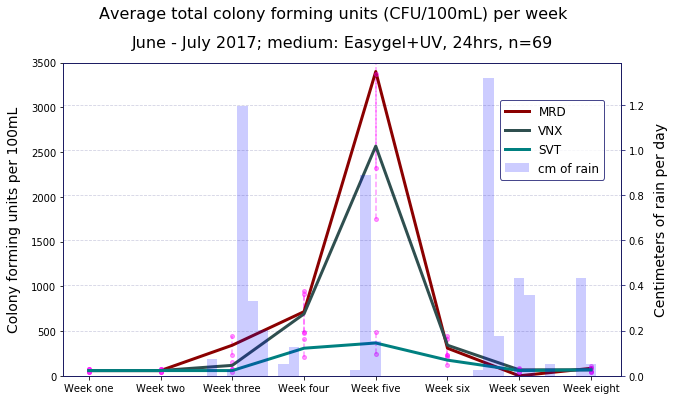

In [35]:
not_simple_plot(8, t_cfu17,samp_date17,  date_list17, places,rain_2017[7:], week_days, 'Average total colony forming units (CFU/100mL) per week', 'June - July 2017; medium: Easygel+UV, 24hrs, n=69', 'cfu_week.png')

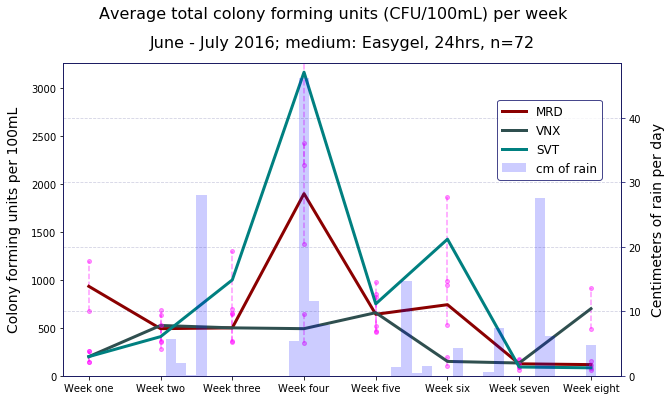

In [36]:
not_simple_plot(8, t_cfu,samp_date,  date_list, places,rain_2016[7:], week_days, 'Average total colony forming units (CFU/100mL) per week', 'June - July 2016; medium: Easygel, 24hrs, n=72', 'cfu_week_16.png')

In [37]:
def total_ecoli_16(c, v, q):
    b = {}
    for n, x in enumerate(v):
        e = []
        for i, w in enumerate(c):        
            if type(q[n][v[n]][i][0][w]) == list:
                a = q[n][v[n]][i][0][w][0]#<---- changed
                
                d = np.mean(a)
                
            elif type(q[n][v[n]][i][0][w]) == dict:
                d=np.mean(e)
            e.append(d)
        f = np.std(e)
        string = x + '_std'
        b.update({x:e, string:f})
        #print(b)
    
    return b

In [38]:
total_big_blue_16 = total_ecoli_16(week_days,places, bar_charts,)

In [39]:
# will have to modify the fucntion a little to grab the 1st (uv) and 3rd element of the list
# something like this:
# four_eight_ave[2]['SVT'][3][0][weeks_l[3]][0:3:2]
# [0:3:2] <-- this last bit means from items 0:3 grab every other item (not including 3)
# and we have to account for the fact that whate ever is coming down may not be a list
def total_big_blue_17(c, v, q):
    b = {}
    for n, x in enumerate(v):
        e = []
        for i, w in enumerate(c):        
            if type(q[n][v[n]][i][0][w]) == list:
                a = q[n][v[n]][i][0][w][1]#<---- changed
                #print(a)
                d = np.sum(a)
            elif type(q[n][v[n]][i][0][w]) == dict:
                d=np.mean(e)
            e.append(d)
        f = np.std(e)
        string = x + '_std'
        b.update({x:e, string:f})
        #print(b)
    
    return b

In [40]:
total_big_blue17 = total_big_blue_17(week_days, places, bar_chart_17)

In [41]:
def make_plots_micro(df):
    i = []
    for b in places:
        a = df[b]
        for c, d in enumerate(a):
            e = a[c]
            f = week_days[c]
            g = b
            h = {'Date':f, 'cfu':e, 'Location':b}
            i.append(h)
            
            
            
    return i
plot_b_blue_17 = make_plots_micro(total_big_blue17)
plot_b_blue_17 = make_plots_micro(total_big_blue_16)
plot_total_17 = make_plots_micro(t_cfu17)
plot_total_16 = make_plots_micro(t_cfu)       

In [42]:
with open('data/date_week16.json', 'wb') as f:
    f.write(json.dumps(date_week16).encode('utf-8'))

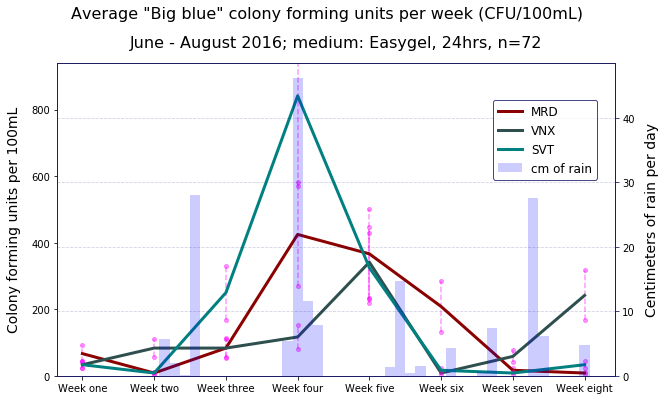

In [43]:
not_simple_plot(8, total_big_blue_16,samp_date,  date_list, places,rain_2016[7:], week_days, 'Average "Big blue" colony forming units per week (CFU/100mL)','June - August 2016; medium: Easygel, 24hrs, n=72', 'data/images/tot_cfu_16.png')

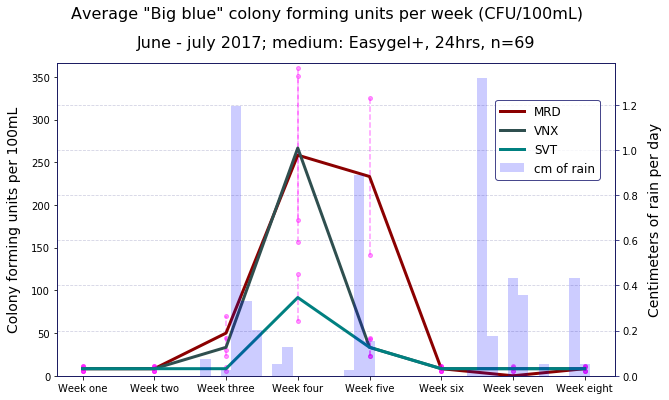

In [44]:
not_simple_plot(8, total_big_blue17,samp_date17,  date_list17, places,rain_2017[7:], week_days,'Average "Big blue" colony forming units per week (CFU/100mL)','June - july 2017; medium: Easygel+, 24hrs, n=69', 'data/images/tot_bblu_17.png')

In [45]:
def total_uv_17(c, v, q):
    b = {}
    for n, x in enumerate(v):
        e = []
        for i, w in enumerate(c):        
            if type(q[n][v[n]][i][0][w]) == list:
                a = q[n][v[n]][i][0][w][0]#<---- changed
                #print(a)
                d = np.sum(a)
            elif type(q[n][v[n]][i][0][w]) == dict:
                d=np.mean(e)
            e.append(d)
        f = np.std(e)
        string = x + '_std'
        b.update({x:e, string:f})
        #print(b)
    
    return b

In [46]:
total_uv17 = total_uv_17(week_days, places, bar_chart_17)

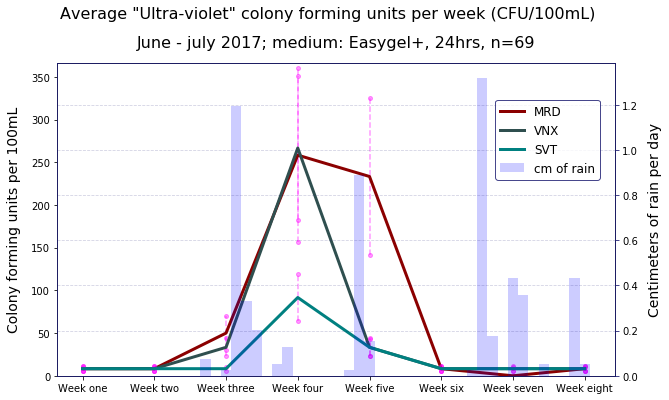

In [47]:
not_simple_plot(8, total_big_blue17,samp_date17,  date_list17, places,rain_2017[7:], week_days,'Average "Ultra-violet" colony forming units per week (CFU/100mL)','June - july 2017; medium: Easygel+, 24hrs, n=69', 'data/images/tot_uv_17.png')

In [48]:
# ok, here is the simple list for your efforts, as possible:
# chart for



# Fig 4A summary figure with both 2016 big blues and 2017 uv+ somehow overlapped with the jazz interval marked
# (this will do electronically)
# Fig 4B same as above, but with total cfus
# Fig 4C to show river UV+ vs sampling sites UV+ ------ maybe later? 
# Fig 4D stats representation of your choice!  (not normal distributions? or??)
# Finally, nice on-line data link with playing and uploading possibilities (like for SLR)…

# ok?  too much??  maybe we already have 2A and 2B
# I can move the sampling site circle for MRD on the fig 1B I think no probs…

# For the scav - of course, no response yet, even with my second note (that gave an auto response, at least).
# Still, they got are request, and will definitely be one of the places we will send the ‘clean draft’ to - after our collaborators comments and prior to submission…
# n’est-ce pas?  (we need a list of all the good addressed to send this to - Montreux folk also, and our Clarens STEP friends)

# will miss you tomorrow (you can change your mind still! ;)
# a+
# Rachel

In [49]:
dates_2017 = sorted(list(date_week.keys()))

In [50]:
place_names={'MRD':'Baye de Montreux', 'SVT':'Quai de Vernex', 'VNX':'Parc de Vernex'}

In [51]:
 def make_series(d,g, file_name):
        a=[]
        for b, c in enumerate(d):
            i = []
            for e, f in enumerate(g[c]):
                f = f.astype(float)
                i.append({'x':dates_2017[e], 'y':round(f, 0), 'location': place_names[c]})
            a.append(i)
        with open('data/json/' + file_name, 'wb') as h:
            h.write(json.dumps(a).encode('utf-8'))
#make_series(places, t_cfu17, 't_cfu_17.json')            

In [52]:
make_series(places, total_uv17, 'total_uv17.json')
make_series(places,total_big_blue17, 'big_blue17.json' )

In [53]:
def make_rain_days(df):
    a =list(df['Date'].dt.strftime("%Y-%m-%d"))
    b = list(df['Rain'])
    c = list(zip(a, b))
    d = d1= [[x[0], x[1]] for x in c]
    return d
rain_17 = make_rain_days(rain_2017)
with open('data/json/rain_17.json', 'wb') as a:
    a.write(json.dumps(rain_17).encode('utf-8'))

In [54]:
dates_2016 = sorted(list(date_week16.keys()))

In [55]:
 def make_series_16(d,g, file_name):
        a=[]
        for b, c in enumerate(d):
            i = []
            for e, f in enumerate(g[c]):
                i.append({'x':dates_2016[e], 'y':round(f, 0), 'location': place_names[c]})
            a.append(i)
        with open('data/json/' + file_name, 'wb') as h:
            h.write(json.dumps(a).encode('utf-8'))


In [56]:
make_series_16(places, total_big_blue_16, 'big_blue16.json')
make_series_16(places, t_cfu, 't_cfu_16.json')

In [57]:
rain_2016.sort_values(by='Date', inplace=True)

In [58]:
rain_16 = make_rain_days(rain_2016)
with open('data/json/rain_16.json', 'wb') as a:
    a.write(json.dumps(rain_16).encode('utf-8'))

In [59]:
hotel_nights = {"June 2016":44451, "July 2016":63896, "August 2016":60500, "June 2017":51409, "July":63675}

In [60]:
rain_2016['rolling'] = rain_2016.rolling(3, min_periods= 1, on='Date').sum()['Rain'].round(2)
rain_2016.fillna(0, inplace=True)

In [61]:
rain_2017['rolling'] = rain_2017.rolling(3, min_periods= 1, on='Date').sum()['Rain'].round(2)
rain_2017.fillna(0, inplace=True)

In [62]:
def get_rolling(b, df):
    e = {}
    for a in b:
#         print(a)
#         print(df)
        c = df.loc[df.Date == a, 'rolling'].item()
        d = {a:c}
        e.update(d)
    return e
r_2016_date = get_rolling(dates_2016, rain_2016)
r_2017_date = get_rolling(dates_2017, rain_2017)
print(r_2016_date, r_2017_date)

{'2016-06-21': 0.0, '2016-06-28': -0.0, '2016-07-05': 0.0, '2016-07-12': 51.64, '2016-07-19': -0.0, '2016-07-26': 1.58, '2016-08-02': 7.47, '2016-08-09': 4.83} {'2017-06-12': 0.0, '2017-06-19': 0.0, '2017-06-26': 0.1, '2017-07-03': 0.18, '2017-07-10': 1.07, '2017-07-17': -0.0, '2017-07-24': 0.61, '2017-07-31': 0.48}


In [63]:
def rain_bug(c, v, q, g, h,t,k):
    b = []
    for n, x in enumerate(v):
        #print(x)
        e = []
        for i, w in enumerate(c):
            if type(q[n][v[n]][i][0][w]) == list:
                a = q[n][v[n]][i][0][w][g]#<---- changed
                d = np.sum(a)
            e.append(d)

            b.append({'x':d, 'y':h[t[w]], 'location':x, 'date': t[w], 'name':k})

    return b
uv_rain_17 = rain_bug(week_days, places, bar_chart_17, 0, r_2017_date, week_date, 'uv')
bb_rain_17 = rain_bug(week_days, places, bar_chart_17, 1, r_2017_date, week_date, 'big blue')
mb_rain_17 = rain_bug(week_days, places, bar_chart_17, 2, r_2017_date, week_date, 'med_blue')
bb_rain_16 = rain_bug(week_days, places, bar_charts, 0, r_2016_date, week_date16, 'big blue 16')
mb_rain_16 = rain_bug(week_days, places, bar_charts, 1, r_2016_date, week_date16, 'med blue 16')

In [65]:
hotel_nights = {2016:{6:44451, 7:63896, 8:60500}, 2017:{6:51409, 7:63675}}

In [66]:
def get_x_y_date(b):
    xs = []
    ys = []
    sz = []
    ds = []
    dct = []
    n = []
    for a in b:
        if a['date'] in dates_2016:
            #print('true')
            xs.append(a['location'])
            ys.append(a['x'])
            sz.append((a['y']+10))
            ds.append(date_week16[a['date']])
            dct.append({date_week16[a['date']]:a['x']})
            n.append({'week':date_week16[a['date']], 'cfu':a['x'], 'name':a['name']})
        elif a['date'] in dates_2017:
            xs.append(a['location'])
            ys.append(a['x'])
            sz.append((a['y']+10))
            ds.append(date_week[a['date']])
            dct.append({date_week[a['date']]:a['x']})
            n.append({'week':date_week[a['date']], 'cfu':a['x'], 'name':a['name']})
    return xs, ys, sz, ds, dct, n
r_uvx_2017 = get_x_y_date(uv_rain_17)
r_bbx_2017 = get_x_y_date(bb_rain_17)
r_mbx_2017 = get_x_y_date(mb_rain_17)
r_bbx_2016 = get_x_y_date(bb_rain_16)
r_mbx_2016 = get_x_y_date(mb_rain_16)

In [67]:
import seaborn as sns
list_o_data = [r_uvx_2017,r_bbx_2017, r_mbx_2017, r_bbx_2016, r_mbx_2016]

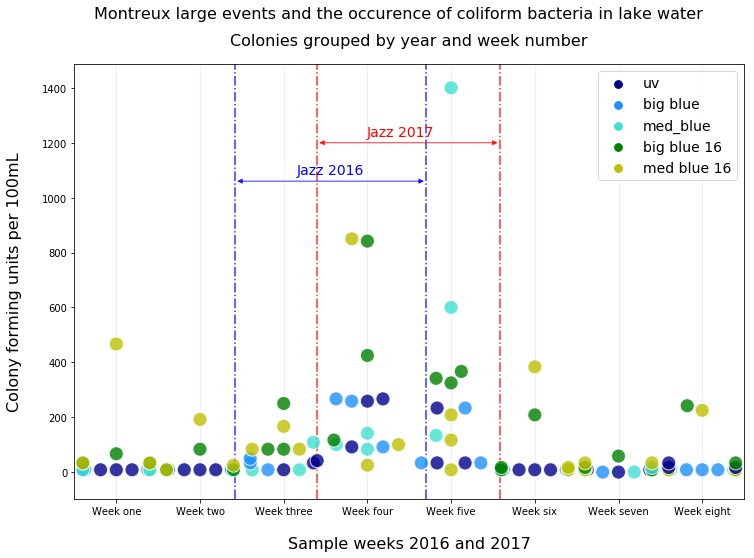

In [68]:
import matplotlib.ticker as mtick
def make_dfs(h,n):
    colors = ['#00008b', '#1e90ff', '#40e0d0', 'g', 'y']
    fig, ax = plt.subplots(figsize=(12,8))
    b = []
    for dat in h:
        for j in dat[n]:
            b.append(j)
    c = pd.DataFrame(b)
    sns.set_palette(colors)
    ax=sns.swarmplot(x='week', y='cfu', hue='name', data=c,  alpha=0.8, size= 14, linewidth=1, edgecolor='w')
    plt.axvline(x=1.42, color='b', linestyle='-.', alpha=0.8)
    plt.axvline(x=3.7, color='b', linestyle='-.', alpha=0.8)
    ax.text(2.56, 1100,  "Jazz 2016", ha="center", va="center", size=14, color='b')
    ax.annotate("", xy=(1.42, 1060), xycoords='data',
               xytext=(3.7, 1060), textcoords='data',
               arrowprops=dict(arrowstyle="<|-|>", connectionstyle="arc3", color='b', alpha=0.8))
    plt.axvline(x=2.4, color='r', linestyle='-.', alpha=0.8)
    plt.axvline(x=4.58, color='r', linestyle='-.', alpha=0.8)
    ax.text(3.4, 1240,  "Jazz 2017", ha="center", va="center", size=14, color='r')
    ax.annotate("", xy=(2.4, 1200), xycoords='data',
               xytext=(4.58, 1200), textcoords='data',
               arrowprops=dict(arrowstyle="<|-|>", connectionstyle="arc3", color='r', alpha=0.8))
    ax.xaxis.grid(which="major", color='b', linewidth=0.7, alpha=0.1)
    ax.set_xlabel("Sample weeks 2016 and 2017", size=16, labelpad=20)
    ax.set_ylabel("Colony forming units per 100mL", size=16, labelpad=20)
    plt.suptitle("Montreux large events and the occurence of coliform bacteria in lake water" , fontsize=16, family='sans')
    plt.title("Colonies grouped by year and week number", fontsize=16, family='sans', y=1.03)
    ax.legend(loc='upper right', fontsize=14)
    plt.savefig('data/images/jazz_dif.svg')
   
    
make_dfs(list_o_data, 5)

In [69]:
def get_x_y_hotel(b):
    xs = []
    ys = []
    sz = []
    ds = []
    dct = []
    n = []
    for a in b:
        f = pd.to_datetime(a['date'])
        d = f.month
#         print(d)
        e = f.year
#         print(e)
        if a['date'] in dates_2016:
            #print('true')
            xs.append(a['location'])
            ys.append(a['x'])
            sz.append((a['y']+10))
            ds.append(date_week16[a['date']])
            dct.append({date_week16[a['date']]:a['x']})
            n.append({'week':date_week16[a['date']], 'cfu':a['x'], 'name':a['name'], 'nights':hotel_nights[e][d], 'rain':a['y']})
        elif a['date'] in dates_2017:
            xs.append(a['location'])
            ys.append(a['x'])
            sz.append((a['y']+10))
            ds.append(date_week[a['date']])
            dct.append({date_week[a['date']]:a['x']})
            n.append({'week':date_week[a['date']], 'cfu':a['x'], 'name':a['name'], 'nights':hotel_nights[e][d], 'rain':a['y']})
    return xs, ys, sz, ds, dct, n

In [70]:
h_uvx_2017 = get_x_y_hotel(uv_rain_17)
h_bbx_2017 = get_x_y_hotel(bb_rain_17)
h_mbx_2017 = get_x_y_hotel(mb_rain_17)
h_bbx_2016 = get_x_y_hotel(bb_rain_16)
h_mbx_2016 = get_x_y_hotel(mb_rain_16)

In [71]:
hotel_night=[h_uvx_2017,h_bbx_2017,h_mbx_2017,h_bbx_2016,h_mbx_2016]

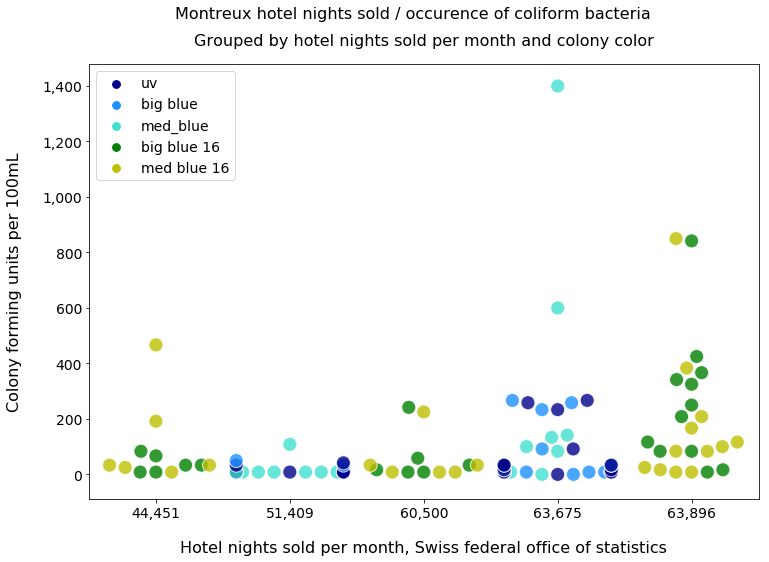

In [77]:
def make_dfs_h(h,n):
    colors = ['#00008b', '#1e90ff', '#40e0d0', 'g', 'y']
    fig, ax = plt.subplots(figsize=(12,8))
    b = []
    for dat in h:
        for j in dat[n]:
            b.append(j)
    c = pd.DataFrame(b)
    d = sorted(list(c['nights'].unique()))
    d = [f"{x:,d}" for x in d]
    #print(d)
    sns.set_palette(colors)
    fmt = '{%x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda y,  p: format(int(y), ',')))
    ax=sns.swarmplot(x='nights', y='cfu', hue='name', data=c,  alpha=0.8, size= 14, linewidth=1, edgecolor='w')
    ax.set_xlabel("Hotel nights sold per month, Swiss federal office of statistics", size=16, labelpad=20)
    ax.set_ylabel("Colony forming units per 100mL", size=16, labelpad=20)
    plt.suptitle("Montreux hotel nights sold / occurence of coliform bacteria" , fontsize=16, family='sans', )
    plt.title("Grouped by hotel nights sold per month and colony color", fontsize=16, family='sans', y=1.03)
    ax.legend(loc='upper left', fontsize=14)
    locs, labels = plt.xticks()
    plt.xticks(locs,d, size=14)
    plt.yticks(size=14)
    plt.savefig('data/images/hotel_dif.svg')
    

make_dfs_h(hotel_night, 5)

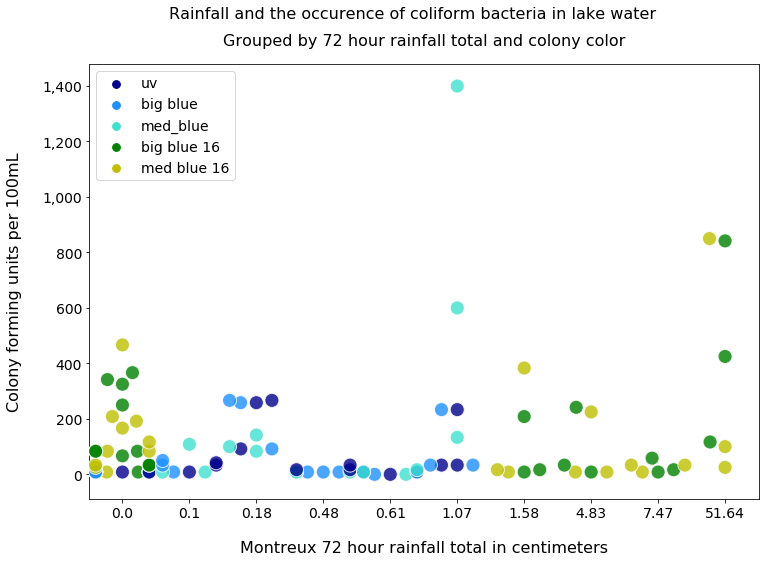

In [79]:
def make_dfs_r(h,n):
    colors = ['#00008b', '#1e90ff', '#40e0d0', 'g', 'y']
    fig, ax = plt.subplots(figsize=(12,8))
    b = []
    for dat in h:
        for j in dat[n]:
            b.append(j)
    c = pd.DataFrame(b)
    sns.set_palette(colors)
    fmt = '{%x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda y,  p: format(int(y), ',')))    
    ax=sns.swarmplot(x='rain', y='cfu', hue='name', data=c,  alpha=0.8, size= 14, linewidth=1, edgecolor='w')
    ax.set_xlabel("Montreux 72 hour rainfall total in centimeters", size=16, labelpad=20)
    ax.set_ylabel("Colony forming units per 100mL", size=16, labelpad=20)
    plt.suptitle("Rainfall and the occurence of coliform bacteria in lake water" , fontsize=16,family='sans')
    plt.title("Grouped by 72 hour rainfall total and colony color", fontsize=16, family='sans', y=1.03)
    ax.legend(loc='upper left', fontsize=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('data/images/rain_dif.svg')
    
make_dfs_r(hotel_night, 5)